## POS tagging using modified Viterbi

### Objectives
- Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 
- Solve the problem of unknown words using at least two techniques. These techniques can use any of the approaches discussed in the class - lexicon, rule-based, probabilistic etc. Note that to implement these techniques, you can either write separate functions and call them from the main Viterbi algorithm, or modify the Viterbi algorithm, or both.
- Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
- List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.

### Data Preparation

In [1]:
#Importing libraries
import nltk, re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
nltk_data

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

In [3]:
# split data into train & test
random.seed(1234)
train_set,test_set = train_test_split(nltk_data,test_size=0.05)

print("Size of training data ", len(train_set))
print("Size of test data ", len(test_set))
print("\n")
print(train_set[:5])

Size of training data  3718
Size of test data  196


[[('New', 'NOUN'), ('York', 'NOUN'), ('City', 'NOUN'), (':', '.')], [('But', 'CONJ'), ('company', 'NOUN'), ('officials', 'NOUN'), ('said', 'VERB'), ('yesterday', 'NOUN'), ('that', 'ADP'), ('they', 'PRON'), ('decided', 'VERB'), ('*-2', 'X'), ('to', 'PRT'), ('take', 'VERB'), ('a', 'DET'), ('$', '.'), ('43', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('pretax', 'ADJ'), ('charge', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('period', 'NOUN'), ('*-3', 'X'), ('to', 'PRT'), ('cover', 'VERB'), ('a', 'DET'), ('restructuring', 'NOUN'), ('of', 'ADP'), ('world-wide', 'ADJ'), ('manufacturing', 'NOUN'), ('operations', 'NOUN'), (',', '.'), ('*-4', 'X'), ('citing', 'VERB'), ('extended', 'ADJ'), ('weakness', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('market', 'NOUN'), ('as', 'ADV'), ('well', 'ADV'), ('as', 'ADP'), ('a', 'DET'), ('decision', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('switch', 'VERB'), ('to', 'PRT'), ('more', 'ADJ'), ('economical', 'ADJ'), ('pr

In [4]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95654

In [5]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['New',
 'York',
 'City',
 ':',
 'But',
 'company',
 'officials',
 'said',
 'yesterday',
 'that']

In [6]:
# vocabulary
V = set(tokens)
print(len(V))

12081


In [7]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [8]:
print(T)

{'VERB', 'NUM', 'CONJ', 'DET', '.', 'PRT', 'PRON', 'NOUN', 'ADV', 'ADP', 'X', 'ADJ'}


In [9]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

### POS Tagging algorithm using HMM

#### Emission Probability

In [10]:
# compute word given tag: Emission Probability method
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

#### Transition Probability

In [11]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [12]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [13]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [14]:
tags_df

,VERB,NUM,CONJ,DET,.,PRT,PRON,NOUN,ADV,ADP,X,ADJ
VERB,0.168244,0.022262,0.005352,0.133959,0.035138,0.031027,0.035371,0.110766,0.082222,0.092150,0.218740,0.064769
NUM,0.017560,0.186310,0.013095,0.002976,0.117560,0.027679,0.001190,0.349405,0.002679,0.035417,0.212500,0.033631
CONJ,0.154453,0.042208,0.000464,0.120594,0.034323,0.005102,0.058905,0.351113,0.055195,0.051020,0.007885,0.118738
DET,0.040082,0.022403,0.000484,0.005207,0.016832,0.000242,0.003754,0.636595,0.012473,0.009324,0.046621,0.205982
.,0.089138,0.081059,0.058079,0.172352,0.092908,0.002424,0.066068,0.222172,0.051975,0.091203,0.027469,0.045063
PRT,0.405229,0.056536,0.002288,0.097712,0.042484,0.001634,0.016013,0.248366,0.009804,0.021242,0.012418,0.086275
PRON,0.488274,0.007305,0.004998,0.009612,0.039985,0.012687,0.007305,0.208381,0.034602,0.021530,0.092657,0.072664
NOUN,0.146454,0.009267,0.042907,0.013354,0.240331,0.043673,0.004707,0.264740,0.017367,0.175606,0.029407,0.012186
ADV,0.344793,0.031736,0.006942,0.069091,0.135868,0.014876,0.015537,0.032066,0.078678,0.118678,0.023802,0.127934
ADP,0.008355,0.062339,0.000857,0.323372,0.039953,0.001500,0.068766,0.322301,0.013925,0.017031,0.035026,0.106577


#### EDA

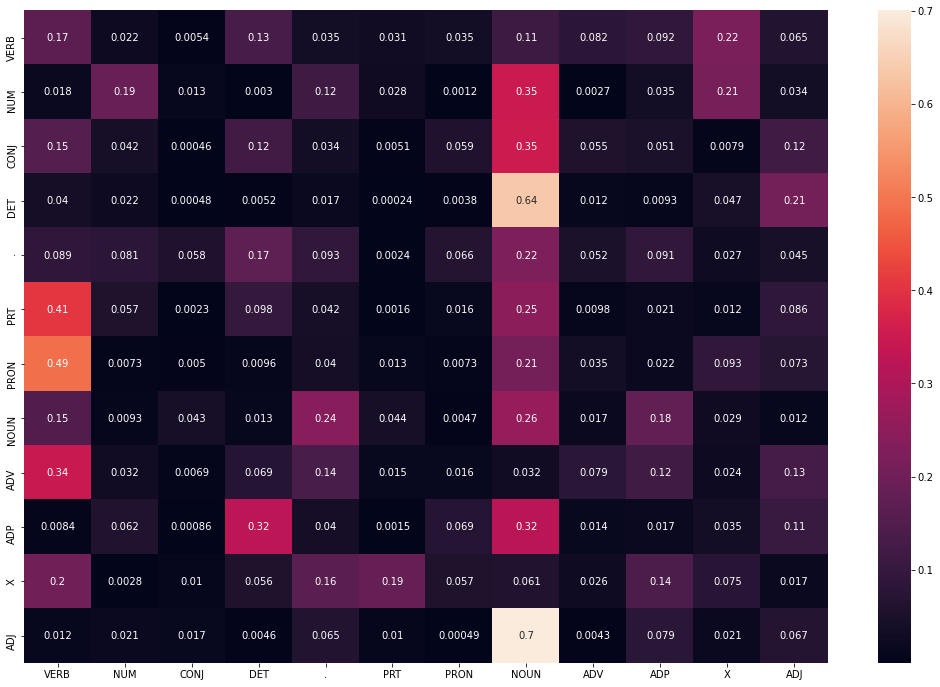

In [15]:
# heatmap of tags matrix
# heat map to know the correlation
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df,annot=True)
plt.show()

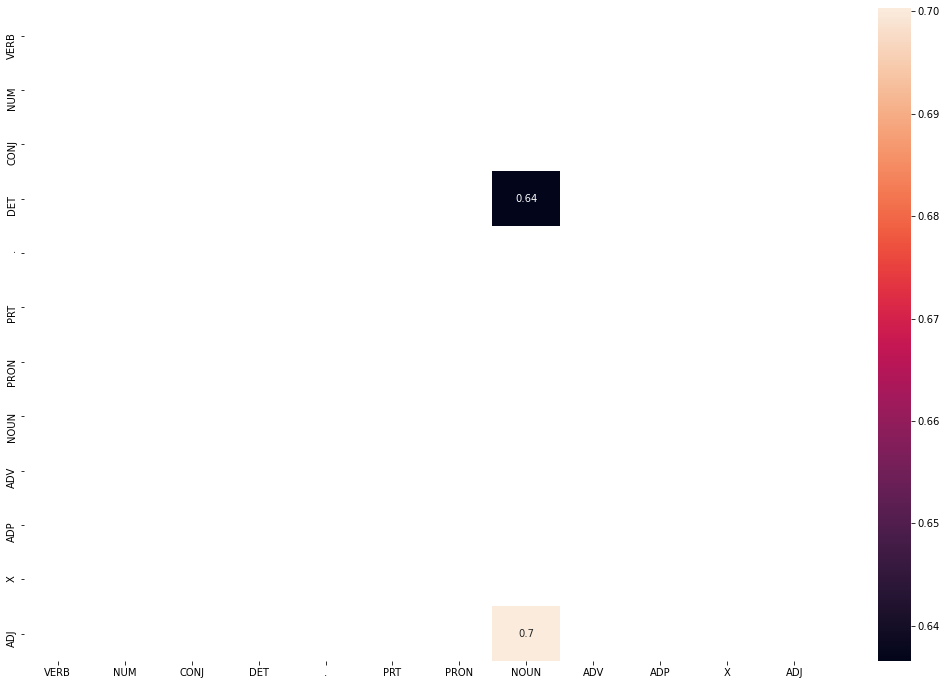

In [16]:
# df where P(t2,t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent,annot=True)
plt.show()

### Build the vanilla Viterbi based POS tagger

In [17]:
# default Viterbi method
def default_Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [18]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('Even', 'ADV'),
  ('before', 'ADP'),
  ('those', 'DET'),
  ('moves', 'NOUN'),
  ('added', 'VERB'),
  ('fuel', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('fires', 'NOUN'),
  ('of', 'ADP'),
  ('discontent', 'NOUN'),
  ('had', 'VERB'),
  ('been', 'VERB'),
  ('well', 'ADV'),
  ('stoked', 'VERB'),
  ('*-1', 'X'),
  ('by', 'ADP'),
  ('the', 'DET'),
  ('highly', 'ADV'),
  ('publicized', 'VERB'),
  ('experience', 'NOUN'),
  ('in', 'ADP'),
  ('Japan', 'NOUN'),
  ('of', 'ADP'),
  ('one', 'NUM'),
  ('U.S.', 'NOUN'),
  ('investor', 'NOUN'),
  (',', '.'),
  ('T.', 'NOUN'),
  ('Boone', 'NOUN'),
  ('Pickens', 'NOUN'),
  ('Jr', 'NOUN'),
  ('.', '.')],
 [('Revenue', 'NOUN'),
  ('rose', 'VERB'),
  ('42', 'NUM'),
  ('%', 'NOUN'),
  ('to', 'PRT'),
  ('$', '.'),
  ('133.7', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('from', 'ADP'),
  ('$', '.'),
  ('94', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('.', '.')],
 [('Government', 'NOUN'),
  ('officials', 'NOUN'),
  (',', '.'),
  ('especially', '

In [19]:
%%time
tagged_seq = default_Viterbi(test_tagged_words)

Wall time: 24.5 s


In [20]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]
accuracy_vanilla_viterbi = len(check)/len(tagged_seq)
print("Accuracy using default Viterbi: ",accuracy_vanilla_viterbi)

Accuracy using default Viterbi:  0.9105691056910569


In [21]:
incorrect_tagged_vanilla_viterbi = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_vanilla_viterbi

[[('added', 'VERB'), (('fuel', 'VERB'), ('fuel', 'NOUN'))],
 [('the', 'DET'), (('fires', 'VERB'), ('fires', 'NOUN'))],
 [('of', 'ADP'), (('discontent', 'VERB'), ('discontent', 'NOUN'))],
 [('Pickens', 'NOUN'), (('Jr', 'VERB'), ('Jr', 'NOUN'))],
 [('$', '.'), (('133.7', 'VERB'), ('133.7', 'NUM'))],
 [('$', '.'), (('94', 'VERB'), ('94', 'NUM'))],
 [('any', 'DET'), (('onslaught', 'VERB'), ('onslaught', 'NOUN'))],
 [('it', 'PRON'), (('off', 'PRT'), ('off', 'ADP'))],
 [('including', 'VERB'), (('low-priced', 'VERB'), ('low-priced', 'ADJ'))],
 [('low-priced', 'ADJ'),
  (('battery-operated', 'VERB'), ('battery-operated', 'ADJ'))],
 [('tariff', 'NOUN'), (('preferences', 'VERB'), ('preferences', 'NOUN'))]]

In [22]:
%%time
## Testing

sentence_test = 'Google and Twitter made a deal in 2015 that gave Google access to Twitter\'s firehose.'
words = word_tokenize(sentence_test)
tagged_seq = default_Viterbi(words)
tagged_seq

Wall time: 3.79 s


[('Google', 'VERB'),
 ('and', 'CONJ'),
 ('Twitter', 'VERB'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'VERB'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'VERB'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'VERB'),
 ("'s", 'PRT'),
 ('firehose', 'VERB'),
 ('.', '.')]

## Solve the problem of unknown words

### Method 1

In [23]:
# Modified Viterbi Heuristic
def Viterbi_for_Unknown_Words(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            # modification to the original vanilla viterbi algorithm 
            # to consider unknown words
            if word not in V:
                state_probability = transition_p
            else:
                state_probability = emission_p * transition_p
                
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [24]:
%%time
# tagging the test sentences
unknown_word_tagged_seq = Viterbi_for_Unknown_Words(test_tagged_words)

# accuracy
unknown_word_check = [i for i, j in zip(unknown_word_tagged_seq, test_run_base) if i == j]

optimized_viterbi_accuracy = len(unknown_word_check)/len(unknown_word_tagged_seq)

print("The accuracy of the Viterbi Algorithm to handle unknown words :", optimized_viterbi_accuracy)

The accuracy of the Viterbi Algorithm to handle unknown words : 0.943089430894309
Wall time: 23.8 s


##### Unigram tagger

In [25]:
unigram_tagger = nltk.UnigramTagger(train_set)
accuracy_unigram_tagger = unigram_tagger.evaluate(test_set)
print(accuracy_unigram_tagger)

0.9058144165671047


In [26]:
patterns = [
    (r'.*ing$', 'VBG'),              # gerund
    (r'.*ed$', 'VBD'),               # past tense
    (r'.*es$', 'VBZ'),               # 3rd singular present
    (r'.*ould$', 'MD'),              # modals
    (r'.*\'s$', 'NN$'),              # possessive nouns
    (r'.*s$', 'NNS'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'CD'), # cardinal numbers
    (r'.*', 'NN')                    # nouns
]


In [27]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

accuracy_lexicon_tagger = lexicon_tagger.evaluate(test_set)
print(accuracy_lexicon_tagger)

0.9058144165671047


##### Bigram tagger

In [28]:
bigram_tagger = nltk.BigramTagger(train_set,backoff=lexicon_tagger)
bigram_tagger.evaluate(test_set)
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)
print(accuracy_bigram_tagger)

0.9090003982477101


##### Trigram tagger

In [29]:
trigram_tagger = nltk.TrigramTagger(train_set, backoff=bigram_tagger)
trigram_tagger.evaluate(test_set)
accuracy_trigram_tagger = trigram_tagger.evaluate(test_set)
print(accuracy_trigram_tagger)

0.9080047789725209


In [30]:
print(T)

{'VERB', 'NUM', 'CONJ', 'DET', '.', 'PRT', 'PRON', 'NOUN', 'ADV', 'ADP', 'X', 'ADJ'}


### Method 2

### Trigram with rule based approach & modified Viterbi

In [31]:
# trigram tagger with rule based
def trigram_tagger(word,train_set = train_set):
    patterns_1 = [
    (r'.*ing$', 'VERB'),              # gerund (ending with 'ing')
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
    (r'.*ould$', 'X'),                # modals
    (r'^(0|([*|-|$].*))','X'),        # Any special character combination
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN')                    # nouns
    ]
    regex_based_tagger = nltk.RegexpTagger(patterns_1)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff=regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [32]:
# Viterbi with handling for unknown words from regex tagger using trigram

def Viterbi_modified(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # unknown words from trigram tagger
        if word not in tokens:
            unk_word_tag=trigram_tagger(word)
            for sent in unk_word_tag:
                for tup in sent:
                    state.append(tup[1])
        
        else:            
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
            
    return list(zip(words, state))

In [33]:
%%time
tagged_seq = Viterbi_modified(test_tagged_words)


Wall time: 43.6 s


#### Evaluating tagging accuracy

In [34]:
# tagging the test sentences
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_tagged_words

['Even',
 'before',
 'those',
 'moves',
 'added',
 'fuel',
 ',',
 'the',
 'fires',
 'of',
 'discontent',
 'had',
 'been',
 'well',
 'stoked',
 '*-1',
 'by',
 'the',
 'highly',
 'publicized',
 'experience',
 'in',
 'Japan',
 'of',
 'one',
 'U.S.',
 'investor',
 ',',
 'T.',
 'Boone',
 'Pickens',
 'Jr',
 '.',
 'Revenue',
 'rose',
 '42',
 '%',
 'to',
 '$',
 '133.7',
 'million',
 '*U*',
 'from',
 '$',
 '94',
 'million',
 '*U*',
 '.',
 'Government',
 'officials',
 ',',
 'especially',
 'in',
 'Japan',
 ',',
 'probably',
 'would',
 'resist',
 'any',
 'onslaught',
 'of',
 'program',
 'trading',
 'by',
 'players',
 'trying',
 '*',
 'to',
 'shrug',
 'off',
 'the',
 'U.S.',
 'furor',
 'over',
 'their',
 'activities',
 'and',
 'marching',
 'abroad',
 'with',
 'their',
 'business',
 '.',
 'But',
 'can',
 'Mr.',
 'Hahn',
 'carry',
 'it',
 'off',
 '?',
 'Timex',
 'is',
 'a',
 'major',
 'U.S.',
 'producer',
 'and',
 'seller',
 'of',
 'watches',
 ',',
 'including',
 'low-priced',
 'battery-operated',
 '

In [35]:
%%time
# tagging the test sentences
tagged_seq_modified = Viterbi_modified(test_tagged_words)
print(tagged_seq_modified)

[('Even', 'ADV'), ('before', 'ADP'), ('those', 'DET'), ('moves', 'NOUN'), ('added', 'VERB'), ('fuel', 'VERB'), (',', '.'), ('the', 'DET'), ('fires', 'VERB'), ('of', 'ADP'), ('discontent', 'NOUN'), ('had', 'VERB'), ('been', 'VERB'), ('well', 'ADV'), ('stoked', 'VERB'), ('*-1', 'X'), ('by', 'ADP'), ('the', 'DET'), ('highly', 'ADV'), ('publicized', 'VERB'), ('experience', 'NOUN'), ('in', 'ADP'), ('Japan', 'NOUN'), ('of', 'ADP'), ('one', 'NUM'), ('U.S.', 'NOUN'), ('investor', 'NOUN'), (',', '.'), ('T.', 'NOUN'), ('Boone', 'NOUN'), ('Pickens', 'NOUN'), ('Jr', 'NOUN'), ('.', '.'), ('Revenue', 'NOUN'), ('rose', 'VERB'), ('42', 'NUM'), ('%', 'NOUN'), ('to', 'PRT'), ('$', '.'), ('133.7', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('from', 'ADP'), ('$', '.'), ('94', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('.', '.'), ('Government', 'NOUN'), ('officials', 'NOUN'), (',', '.'), ('especially', 'ADV'), ('in', 'ADP'), ('Japan', 'NOUN'), (',', '.'), ('probably', 'ADV'), ('would', 'VERB'), ('resist', '

In [36]:
# accuracy
check1 = [i for i, j in zip(tagged_seq_modified, test_run_base) if i == j]
accuracy_viterbi_modified = len(check1)/len(tagged_seq_modified)
accuracy_viterbi_modified

0.943089430894309

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [37]:
print("Accuracy using vanilla viterbi: ",round(100*accuracy_vanilla_viterbi,2))

Accuracy using vanilla viterbi:  91.06


In [38]:
print("Accuracy with unigram: ",round(100*accuracy_unigram_tagger,2))

Accuracy with unigram:  90.58


In [39]:
print("Accuracy with bigram: ",round(100*accuracy_bigram_tagger,2))

Accuracy with bigram:  90.9


In [40]:
print("Accuracy with trigram: ",round(100*accuracy_trigram_tagger,2))

Accuracy with trigram:  90.8


In [41]:
print("Accuracy with rule based tagger: ",round(100*accuracy_lexicon_tagger,2))

Accuracy with rule based tagger:  90.58


In [42]:
print("Accuracy with modified Viterbi: ",round(100*accuracy_viterbi_modified,2))

Accuracy with modified Viterbi:  94.31


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [43]:
# read file from the location
f = open('Test_sentences.txt')

In [44]:
# store the data into "text"
text = f.read()

In [45]:
# split the lines & store as list then close the file
sample_test_sent = text.splitlines()
f.close()

In [46]:
# print the data & type
print(sample_test_sent)
print("\n")
print(type(sample_test_sent))

['Android is a mobile operating system developed by Google.', 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.', "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.", 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.', 'Before entering politics, Donald Trump was a domineering businessman and a television personality.', 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.', 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.', 'Show me the cheapest round trips from Dallas to Atlanta', 'I would like to see flights from Denver to Philadelphia.', 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.', 'NASA invited social media users to experience the laun

#### Case 1

In [47]:
# POS tags with default Viterbi for sentence 1
words = word_tokenize(sample_test_sent[1])
tagged_seq = default_Viterbi(words)
print(tagged_seq)

[('Android', 'VERB'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'VERB'), ('worldwide', 'VERB'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'VERB'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'VERB'), ('.', '.')]


In [48]:
# POS tags with modified Viterbi for sentence 1
tagged_seq_modified = Viterbi_modified(words)
print(tagged_seq_modified)

[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]


#### Case 2

In [49]:
# POS tags with default Viterbi for sentence 2
words = word_tokenize(sample_test_sent[2])
tagged_seq = default_Viterbi(words)
print(tagged_seq)

[('Google', 'VERB'), ('and', 'CONJ'), ('Twitter', 'VERB'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'VERB'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'VERB'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.')]


In [50]:
# POS tags with modified Viterbi for sentence 2
tagged_seq_modified = Viterbi_modified(words)
print(tagged_seq_modified)

[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]


#### Case 3

In [51]:
# POS tags with default Viterbi for sentence 3
words = word_tokenize(sample_test_sent[3])
tagged_seq = default_Viterbi(words)
print(tagged_seq)

[('Twitter', 'VERB'), ('is', 'VERB'), ('an', 'DET'), ('online', 'VERB'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), ('interact', 'VERB'), ('with', 'ADP'), ('messages', 'VERB'), ('known', 'VERB'), ('as', 'ADP'), ('tweets', 'VERB'), ('.', '.')]


In [52]:
# POS tags with modified Viterbi for sentence 3
tagged_seq_modified = Viterbi_modified(words)
print(tagged_seq_modified)

[('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), ('interact', 'NOUN'), ('with', 'ADP'), ('messages', 'VERB'), ('known', 'VERB'), ('as', 'ADP'), ('tweets', 'NOUN'), ('.', '.')]


### Conclusion

#### Method 1
- Transition probability is used for unknown words
- The method shows good accuracy but there are some words which are misclassified 
- The accuracy is around <b>94%</b>

#### Method 2
- Used rule based trigram method
- Modified Viterbi algorithm with rule based trigram gives good accuracy with correct classification of words
- The accuracy was around <b>94.5%</b>